## Import Libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
import subprocess

import json
import csv

import pandas as pd
import numpy as np

from datetime import datetime, date, time

import snscrape.modules.twitter as sntwitter
import yfinance as yf

import re

import time

import glob

from textblob import TextBlob

## scrapeTweets() and dataWrangle() functions

In [4]:
# Keep note of directory_name -- it is based on the stock in question of the form tweets_(STOCK_NAME)
# example: tweets_GME or tweets_TSLA

def scrapeTweets(start, stop, keyword, directory, tweet_limit=1):
    if not os.path.exists(directory): # Creates directory in current directory if doesn't already exist
        os.mkdir(directory)
    
    file_path = os.path.join(directory, f'keyword:{keyword}__start:{start}_end:{stop}__limit:{tweet_limit}.csv')
    
    tweet_list = []
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{keyword} since:{start} until:{stop}').get_items()):
        if i > tweet_limit:
            break
        tweet_list.append([tweet.date, # Appending all tweet data into a list of list
                           tweet.id, 
                           tweet.content, 
                           tweet.user.username, 
                           tweet.user.followersCount, 
                           tweet.hashtags, 
                           tweet.cashtags, 
                           tweet.lang])
    
    df_tweets = pd.DataFrame(tweet_list, columns=['Datetime', # Creating df of tweet data
                                                  'Tweet Id', 
                                                  'Text', 
                                                  'Username', 
                                                  'Followers Count', 
                                                  'Hashtags', 
                                                  'Cashtags', 
                                                  'Language'])
    
    df_tweets.to_csv(file_path, index=False) # Writing df_tweets into new csv file
    
    if os.path.isfile(file_path) == True:
        return print(f'Successfully saved DataFrame to {file_path}')
    else:
        return print('DataFrame not saved -- possible error has occurred.')        

In [5]:
# Creating function to clean dataframes programatically


def dataWrangle(dataframe_list):   
    df_concat = pd.concat(dataframe_list) # Concatenate all the DataFrames from the list of DataFrames
    df_filter = df_concat[df_concat['Language'] == 'en'][['Datetime', # Filter via Language = 'en'
                                                           'Tweet Id', # Remove unwanted columns
                                                           'Text', 
                                                           'Username',
                                                           'Followers Count']] 
    df_clean = df_filter.astype({'Tweet Id':str})\
                        .dropna()\
                        .drop_duplicates()\
                        .reset_index(drop=True)
    
    df_clean['Text'] = (df_clean['Text'] # Cleans out redundant string characters within each tweet
                       .apply(lambda x: ' '.join(re.sub(r'https\S+', '', x)
                                                .replace('\n', ' ')
                                                .split()
                                                )
                             )
                       )
    
    return df_clean
                                               

## Creating DataFrames of Tweets

In [6]:
# List of file names

# Files from two directories -- scraped at different time irl 
# for the same dates within the data

file_path_tweets_GME = glob.glob('tweets_GME/*')
file_path_tweets_scraped = glob.glob('tweets_scraped/*')

In [7]:
# Creating a list of DataFrames using glob's list of files names
df_list = []
for i in file_path_tweets_GME + file_path_tweets_scraped:
    df_list.append(pd.read_csv(i))

In [8]:
start_time = date(2021, 1, 8).strftime('%Y-%m-%d')
stop_time = date(2021, 2, 12).strftime('%Y-%m-%d')

def toDateTimeIndex(df): # year-month-day
    df['Datetime'] = pd.to_datetime(df['Datetime']).dt.floor('d').dt.tz_localize(tz=None)
    df.index = pd.DatetimeIndex(df['Datetime']) # Can use .set_index(<column name>) instead to make function a one liner
    df = df.drop(columns=['Datetime'])
    return df.sort_index()

In [9]:
df = dataWrangle(df_list)

In [11]:
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.floor('d').dt.tz_localize(tz=None)

## Polarity Scores

A list of goals to accomplish: \
    - Figure out polarity/subjectivity scores for every tweet\
    - For now we want to work with dates from 01/21/2021 and onwards as a test\
    - Mess about with distribution of negative/positive/neutral scores to have a healthy balance of samples\
    - Break everything up by days\
    - Move onto bringing in financial data

In [14]:
# Creating column of scores

df['Polarity/Subjectivity Scores'] = df['Text'].apply(lambda text: TextBlob(text).sentiment)

In [17]:
# Cleaning out scores of (0,0)

df_pol_clean = df[df['Polarity/Subjectivity Scores'] != (0.0,0.0)].set_index('Datetime').sort_index()

In [35]:
# Filtering out dates with low tweet volume

df_sorted_dates = df_pol_clean["2021-01-21":][['Text', 'Polarity/Subjectivity Scores']]

In [37]:
df_sorted_dates

,Text,Polarity/Subjectivity Scores
Datetime,,
2021-01-21,"So, Dr. Burry, some free advice for a good guy...","(0.15555555555555559, 0.6611111111111111)"
2021-01-21,"@LizClaman @GameStop @ClamanCountdown Liz, And...","(-0.18787878787878784, 0.4055555555555555)"
2021-01-21,@FarisBakkar @Long_GME E-commerce growth for G...,"(0.05833333333333335, 0.4583333333333333)"
2021-01-21,@FarisBakkar @Long_GME You are honestly recycl...,"(0.049999999999999975, 0.5083333333333333)"
2021-01-21,UPDATE: Citron's Andrew Left On GameStop Short...,"(0.075, 0.3989583333333333)"
...,...,...
2021-02-11,@KChampbell @2009Michael1984 Just think if Blo...,"(0.05393939393939393, 0.4242424242424243)"
2021-02-11,"@aurban22 @RocketCatchnBob Yes, you should be ...","(0.45, 0.7866666666666667)"
2021-02-11,"My retarded question is, since diamond hands a...","(-0.2, 0.45)"


In [112]:
# This may cause imbalances.
# Consider first figuring out polarity scores PER DAY

def polarityCategories(tup):
    if tup[0] < -0.01:
        return 'Negative'
    elif tup[0] > 0.2:
        return 'Positive'
    else:
        return 'Neutral'

In [114]:
# Creating new column with polarity categories: Positive, Neutral, Negative

df_sorted_dates['Polarity Categories'] = df_sorted_dates['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories(x))

In [115]:
# Seemingly balanced values

df_sorted_dates.value_counts('Polarity Categories')

Polarity Categories
Neutral     28920
Positive    23751
Negative    21319
dtype: int64

In [128]:
df_sorted_dates

,Text,Polarity/Subjectivity Scores,Polarity Categories
Datetime,,,
2021-01-21,"So, Dr. Burry, some free advice for a good guy...","(0.15555555555555559, 0.6611111111111111)",Neutral
2021-01-21,"@LizClaman @GameStop @ClamanCountdown Liz, And...","(-0.18787878787878784, 0.4055555555555555)",Negative
2021-01-21,@FarisBakkar @Long_GME E-commerce growth for G...,"(0.05833333333333335, 0.4583333333333333)",Neutral
2021-01-21,@FarisBakkar @Long_GME You are honestly recycl...,"(0.049999999999999975, 0.5083333333333333)",Neutral
2021-01-21,UPDATE: Citron's Andrew Left On GameStop Short...,"(0.075, 0.3989583333333333)",Neutral
...,...,...,...
2021-02-11,@KChampbell @2009Michael1984 Just think if Blo...,"(0.05393939393939393, 0.4242424242424243)",Neutral
2021-02-11,"@aurban22 @RocketCatchnBob Yes, you should be ...","(0.45, 0.7866666666666667)",Positive
2021-02-11,"My retarded question is, since diamond hands a...","(-0.2, 0.45)",Negative


## Categorizing polarity scores per day

Our goal here is to quantify one polarity score per day. We do this individually per day based on the distribution of the scores; if the distribution is skewed, we use the median, if it isn't we use mean.

In [ ]:
# We will use this section to approach this problem at a different angle.

## Stock Data

In [129]:
# Get the data for $GME by specifying the stock ticker, start date, and end date
data_stock_gme = yf.download('GME','2021-01-21','2021-02-12')
data_stock_gme.index = data_stock_gme.index.tz_localize(tz=None)

[*********************100%***********************]  1 of 1 completed


In [137]:
data_stock_gme['Closing Differences'] = data_stock_gme['Close'].diff()
data_stock_gme['C-O/O'] = ((data_stock_gme['Close']-data_stock_gme['Open'])/data_stock_gme['Open'])*100

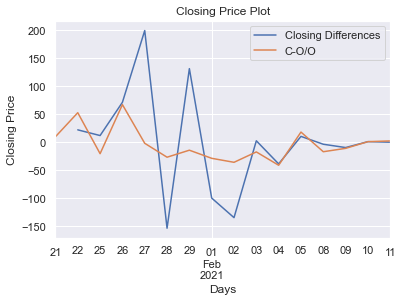

In [140]:
# Plot

data_stock_gme[['Closing Differences', 'C-O/O']].plot()

# plt.ylim(-120, 120)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

In [141]:
data_stock_gme

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,C-O/O
Date,,,,,,,,
2021-01-21,39.230000,44.750000,37.000000,43.029999,43.029999,56216900,NaN,9.686463
2021-01-22,42.590000,76.760002,42.320000,65.010002,65.010002,197157900,21.980003,52.641470
2021-01-25,96.730003,159.179993,61.130001,76.790001,76.790001,177874000,11.779999,-20.614082
2021-01-26,88.559998,150.000000,80.199997,147.979996,147.979996,178588000,71.189995,67.095754
2021-01-27,354.829987,380.000000,249.000000,347.510010,347.510010,93396700,199.530014,-2.062953
2021-01-28,265.000000,483.000000,112.250000,193.600006,193.600006,58815800,-153.910004,-26.943394
2021-01-29,379.709991,413.980011,250.000000,325.000000,325.000000,50566100,131.399994,-14.408362
2021-02-01,316.559998,322.000000,212.000000,225.000000,225.000000,37382200,-100.000000,-28.923426
2021-02-02,140.759995,158.000000,74.220001,90.000000,90.000000,78183100,-135.000000,-36.061379
